```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. 

```

# Regression Metrics and Evaluation

### Regression analysis
`Regression analysis` models the relationships between a response variable and one or more predictor variables. 
- Use a regression model to understand how changes in the predictor values are associated with changes in the response mean. 
- You can also use regression to make predictions based on the values of the predictors. 

There are a variety of regression methodologies that you choose based on the type of response variable, the type of model that is required to provide an adequate fit to the data, and the estimation method.

In [1]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src') 

In [2]:
from datasets import (
    get_dataset
)

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# To eliminate Yellowbrick warming: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
import matplotlib.font_manager

import seaborn as sns

In [4]:
df = get_dataset('boston_housing')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [5]:
# Missing values?
df.isnull().mean().value_counts()

0.0    14
dtype: int64

In [6]:
y = df[['medv']]
X = df.drop(columns=['medv'])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=42, n_estimators=1000, n_jobs=-1)
rfr.fit(X_train, y_train.values.ravel())

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=42)

## Metrics
The [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) module includes metrics to evaluate regression models. **Metric functions ending in `loss` or `error` should be minimized. Functions ending in `score` should be maximized.**

In [9]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

### Coefficient of Determination (R²)
The `coefficient of determination (r²)` is a common regression metric (goodness-of-fit measure). This value is typically between 0 and 1. It represents the percentage of the variance of the target that the features contribute (the percentage of the variance in the dependent variable that the independent variables explain collectively). R-squared measures the strength of the relationship between your model and the dependent variable on a convenient 0 – 100% scale. Higher values are better, but in general it is difficult to evaluate the model from this metric alone. Does a .7 mean it is a good score? It depends. For a given dataset, .5 might be a good score, while for another dataset, a .9 may be a bad score. In addition, small R-squared values are not always a problem, and high R-squared values are not necessarily good. Typically we use this number in combination with other metrics or visualizations to evaluate a model.

The r² metric is the default metric used during grid search. You can specify other metrics using the `scoring` parameter.

Before assessing numeric measures of goodness-of-fit, like `R-squared`, you should evaluate the `residual plots`. Residual plots can expose a biased model far more effectively than the numeric output by displaying problematic patterns in the residuals. If your model is biased, you cannot trust the results. If your residual plots look good, go ahead and assess your R-squared and other statistics.

`R-squared` evaluates the scatter of the data points around the fitted regression line. It is also called the `coefficient of determination`, or the `coefficient of multiple determination` for multiple regression. For the same data set, higher R-squared values represent smaller differences between the observed data and the fitted values. `R-squared` is the percentage of the dependent variable variation that a linear model explains.

<img src="images/regression_r2.png" style="width: 300px;"/>

R-squared is always between 0 and 100%:

- 0% represents a model that does not explain any of the variation in the response variable around its mean. The mean of the dependent variable predicts the dependent variable as well as the regression model.
- 100% represents a model that explains all of the variation in the response variable around its mean.

Usually, the larger the R2, the better the regression model fits your observations. However, this guideline has important caveats.
- You cannot use R-squared to determine whether the coefficient estimates and predictions are biased, which is why you must assess the residual plots.
- R-squared does not indicate if a regression model provides an adequate fit to your data. A good model can have a low R2 value. On the other hand, a biased model can have a high R2 value!

To visually demonstrate how R-squared values represent the scatter around the regression line, you can plot the fitted values by observed values.

<img src="images/regression_r2_02.png" style="width: 600px;"/>

The R-squared for the regression model on the left is 15%, and for the model on the right it is 85%. When a regression model accounts for more of the variance, the data points are closer to the regression line. In practice, you’ll never see a regression model with an R2 of 100%. In that case, the fitted values equal the data values and, consequently, all of the observations fall exactly on the regression line.

Regression models with low R-squared values can be perfectly good models for several reasons.
- Some fields of study have an inherently greater amount of unexplainable variation. In these areas, your R2 values are bound to be lower. For example, studies that try to explain human behavior generally have R2 values less than 50%. People are just harder to predict than things like physical processes.
- Fortunately, if you have a low R-squared value but the independent variables are statistically significant, you can still draw important conclusions about the relationships between the variables. Statistically significant coefficients continue to represent the mean change in the dependent variable given a one-unit shift in the independent variable. Clearly, being able to draw conclusions like this is vital.
- There is a scenario where small R-squared values can cause problems. If you need to generate predictions that are relatively precise (narrow prediction intervals), a low R2 can be a show stopper.
- High R2 values are not always a problem. In fact, sometimes you can legitimately expect very large values. For example, if you are studying a physical process and have very precise and accurate measurements, it’s possible to obtain valid R-squared values in the high 90s. On the other hand, human behavior inherently has much more unexplainable variability, and this produces R2 values that are usually less than 50%. 90% is way too high in this context!
- You need to use your knowledge of the subject area to determine what R2 values are reasonable. Compare your study to comparable studies to see what values they obtained. 

How high does R-squared need to be for the model produce useful predictions? That depends on the precision that you require and the amount of variation present in your data. A high R2 is necessary for precise predictions, but it is not sufficient by itself.

A regression model with a high R-squared value can have a multitude of problems. You probably expect that a high R2 indicates a good model but examine the graphs below. The fitted line plot models the association between electron mobility and density.

<img src="images/regression_r2_03.png" style="width: 600px;"/>

The data in the fitted line plot follow a very low noise relationship, and the `R-squared` is 98.5%, which seems fantastic. However, the regression line consistently under and over-predicts the data along the curve, which is bias. The `Residuals` versus Fits plot emphasizes this unwanted pattern. An unbiased model has `residuals` that are randomly scattered around zero. `Non-random residual patterns indicate a bad fit despite a high R2`. **Always check your residual plots!** This type of specification bias occurs when your linear model is underspecified. In other words, it is missing significant independent variables, polynomial terms, and interaction terms. `To produce random residuals, try adding terms to the model or fitting a nonlinear model`.

If your R-squared value is too high, consider the following potential explanations:
- **Reason 1: R-squared is a biased estimate** The R-squared value in your regression output has a tendency to be too high. When calculated from a sample, R2 is a biased estimator. In statistics, a biased estimator is one that is systematically higher or lower than the population value. R-squared estimates tend to be greater than the correct population value. This bias causes some researchers to avoid R2 altogether and use adjusted R2 instead. Linear regression methodology gets tripped up by chance correlations that are present in the sample, which causes an inflated R2.
- **Reason 2: Overfitting your model** Overfitting a model is a condition where a statistical model begins to describe the random error in the data rather than the relationships between variables. This problem occurs when the model is too complex. Unfortunately, one of the symptoms of an overfit model is an R-squared value that is too high. While the R2 looks good, there can be serious problems with an overfit model. For one thing, the regression coefficients represent the noise rather than the genuine relationships in the population. Additionally, an overfit regression model is tailor-made to fit the random quirks of one sample and is unlikely to fit the random quirks of another sample. Thus, overfitting a regression model reduces its generalizability outside the original dataset. Adjusted R-squared isn’t designed to detect overfitting, but predicted R-squared can.
- **Reason 3: Data mining and chance correlations** Data mining is the process of fitting many different models, trying many different independent variables, and primarily using statistical significance to build the final model rather than being guided by theory. This process introduces a variety of problems, including misleading coefficients and an inflated R-squared value. For all hypothesis tests, including tests for regression coefficients, there is always the chance of rejecting a null hypothesis that is actually true (Type I error). This error rate equals your significance level, which is often 5%. If you use an automated model building procedure like stepwise or best subsets regression, you might be performing hundreds if not thousands of hypothesis tests on your sample. With this many tests, you will inevitably encounter false positives. If you are guided mainly by statistical significance, you’ll keep these variables in the model. The answer lies in conducting subject-area research before you begin your study. This research helps you reduce the number of models you fit and allows you to compare your results to theory.
- **Reason 4: Trends in Panel (Time Series) Data** If you have panel data and your dependent variable and an independent variable both have trends over time, this can produce inflated R-squared values. Try a time series analysis or include time-related independent variables in your regression model. For instance, try lagging and differencing your variables.
- **Reason 5: Form of a Variable** If you include a different form of the same variable for both the dependent variable and an independent variable, you obtain an artificially inflated R-squared. For example, if the dependent variable is temperature in Celsius and your model contains an independent variable of temperature on a different scale, your R2 is nearly 100%. That’s an obvious example, but there are more subtle forms of it. For instance, you can expect an inflated R2 value if your dependent variable is poverty rate and one of your independent variables is income. Poverty rate is defined by income.

How serious is this problem? The answer lies in conducting subject-area research before you begin your study. This research helps you reduce the number of models you fit and allows you to compare your results to theory.

A variety of other circumstances can artificially inflate your R2. These reasons include overfitting the model and data mining. Either of these can produce a model that looks like it provides an excellent fit to the data but in reality the results can be entirely deceptive. An overfit model is one where the model fits the random quirks of the sample. Data mining can take advantage of chance correlations. In either case, you can obtain a model with a high R2 even for entirely random data!

At first glance, `R-squared` seems like an easy to understand statistic that indicates how well a regression model fits a data set. However, it doesn’t tell us the entire story. To get the full picture, you must consider R2 values in combination with residual plots, other statistics, and in-depth knowledge of the subject area.

The `.score` method calculates this for regression models.

In [10]:
from sklearn import metrics

rfr.score(X_test, y_test)

0.8763367508673342

In [11]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
metrics.r2_score(y_test, rfr.predict(X_test))

0.8763367508673343

There is also an explained variance metric (`explained_variance` in grid search). If the mean of the residuals (errors in predictions) is 0 (in ordinary least squares (OLS) models), then the variance explained is the same as the coefficient of determination.

In [12]:
metrics.explained_variance_score(y_test, rfr.predict(X_test))

0.8765301856464149

### Standard Error of the Regression (S)
The `standard error of the regression (S)`, also known as the `standard error of the estimate`, represents the average distance that the observed values fall from the regression line. Conveniently, it tells you how wrong the regression model is on average using the units of the response variable. Smaller values are better because it indicates that the observations are closer to the fitted line.

Unlike `R-squared`, you can use the `standard error of the regression` to assess the precision of the predictions. `Approximately 95% of the observations should fall within plus/minus 2*standard error of the regression from the regression line, which is also a quick approximation of a 95% prediction interval`. If want to use a regression model to make predictions, assessing the standard error of the regression might be more important than assessing R-squared.

#### Comparison of R-squared to the Standard Error of the Regression (S)
Both of these measures give you a numeric assessment of how well a model fits the sample data. However, there are differences between the two statistics.

<img src="images/regression_s.png" style="width: 300px;"/>

- The `standard error of the regression` provides **the absolute measure** of the typical distance that the data points fall from the regression line. S is in the units of the dependent variable.
- `R-squared` provides the relative **measure of the percentage** of the dependent variable variance that the model explains. R-squared can range from 0 to 100%. R-squared doesn’t have any units, and it feels more ambiguous than S. If all we know is that R-squared is XX%, we don’t know how wrong the model is on average. You do need a high R-squared to produce precise predictions, but you don’t know how high it must be exactly. It’s impossible to use R-squared to evaluate the precision of the predictions.

An analogy makes the difference very clear. Suppose we’re talking about how fast a car is traveling.

`R-squared` is equivalent to saying that the car went 80% faster. That sounds a lot faster! However, it makes a huge difference whether the initial speed was 20 MPH or 90 MPH. The increased velocity based on the percentage can be either 16 MPH or 72 MPH, respectively. One is lame, and the other is very impressive. If you need to know exactly how much faster, the relative measure just isn’t going to tell you.

The `standard error of the regression` is equivalent to telling you directly how many MPH faster the car is traveling. The car went 72 MPH faster. Now that’s impressive!

The `standard error of the regression` has several advantages. 
- S tells you straight up how precise the model’s predictions are using the units of the dependent variable. This statistic indicates how far the data points are from the regression line on average. You want lower values of S because it signifies that the distances between the data points and the fitted values are smaller. 
- S is also valid for both linear and nonlinear regression models. This fact is convenient if you need to compare the fit between both types of models.

For `R-squared`, you want the regression model to explain higher percentages of the variance. 
- Higher R-squared values indicate that the data points are closer to the fitted values. While higher R-squared values are good, they don’t tell you how far the data points are from the regression line. 
- Additionally, R-squared is valid for only linear models. `You can’t use R-squared to compare a linear model to a nonlinear model`.

Note: Linear models can use polynomials to model curvature. I’m using the term linear to refer to models that are linear in the parameters.

### Mean Absolute Error (MAE)
`Mean absolute error` (`neg_mean_absolute_error` when used in grid search) expresses the average absolute model prediction error. A perfect model would score 0, but this metric has no upper bounds, unlike the coefficient of determination. However, since **it is in units of the target, it is more interpretable**. If you want to ignore outliers, this is a good metric to use.

This measure cannot indicate how bad a model is, but can be used to compare two models. If you have two models, the model with a lower score is better.

This number tells us that the average error is about two above or below the real value.

In [13]:
metrics.mean_absolute_error(y_test, rfr.predict(X_test))

2.072138815789479

### Root Mean Squared Error (RMSE)
`Root mean squared error` (`neg_mean_squared_error` in grid search) also measures model error in terms of the target. However, because it averages the square of errors before taking the square root, **it penalizes large errors**. If you want to penalize large errors, this is a good metric to use. For example, if being off by eight is more than two times worse than being off by four.

As with `mean absolute error`, this measure cannot indicate how bad a model is, but can be used to compare two models. If you assume that errors are normally distributed, this is a good choice.

The result tells us if we square the errors and average them, the result will be around 9.5

In [14]:
metrics.mean_squared_error(y_test, rfr.predict(X_test))

9.214531500855275

### Mean Squared Logarithmic Error (MSLE)
The `mean squared logarithmic error` (in grid search, `neg_mean_squared_log_error`) **penalizes underprediction more than overprediction**. If you have targets that experience exponential growth (population, stock, etc.), this is a good metric.

If you take the log of the error and then square it, the average of these results will be 0.021.

In [15]:
metrics.mean_squared_log_error(y_test, rfr.predict(X_test))

0.02122917655324258

## Residuals Plot
Good models (with appropriate `R2 scores`) will exhibit `homoscedasticity`. This means the variance is the same for all values of targets regardless of the input. Plotted, this looks like randomly distributed values in a residuals plot. **If there are patterns, the model or the data are problematic**.

Before assessing numeric measures of goodness-of-fit, like `R-squared`, you should evaluate the `residual plots`. Residual plots can expose a biased model far more effectively than the numeric output by displaying problematic patterns in the residuals. If your model is biased, you cannot trust the results. If your residual plots look good, go ahead and assess your R-squared and other statistics.

**Residuals plots also show outliers**, which can have a big impact on model fitting.

In [16]:
X_train

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21
116,0.13158,0.0,10.01,0,0.547,6.176,72.5,2.7301,6,432,17.8,393.30,12.04
45,0.17142,0.0,6.91,0,0.448,5.682,33.8,5.1004,3,233,17.9,396.90,10.21
16,1.05393,0.0,8.14,0,0.538,5.935,29.3,4.4986,4,307,21.0,386.85,6.58
468,15.57570,0.0,18.10,0,0.580,5.926,71.0,2.9084,24,666,20.2,368.74,18.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.17120,0.0,8.56,0,0.520,5.836,91.9,2.2110,5,384,20.9,395.67,18.66
270,0.29916,20.0,6.96,0,0.464,5.856,42.1,4.4290,3,223,18.6,388.65,13.00
348,0.01501,80.0,2.01,0,0.435,6.635,29.7,8.3440,4,280,17.0,390.94,5.99
435,11.16040,0.0,18.10,0,0.740,6.629,94.6,2.1247,24,666,20.2,109.85,23.27


In [17]:
y_train

,medv
5,28.7
116,21.2
45,19.3
16,23.1
468,19.1
...,...
106,19.5
270,21.1
348,24.5
435,13.4


In [18]:
from yellowbrick.regressor import ResidualsPlot

def show_residuals_plot(model, X_train, y_train, X_test, y_test):
    
    print(type(X_train))
    print(X_train.shape)
    print(y_train.shape)

    fig, ax = plt.subplots(figsize=(12, 8))
    rpv = ResidualsPlot(model)
    rpv.fit(X_train, y_train)
    rpv.score(X_test, y_test)
    rpv.poof()
    #fig.savefig("images/regression_metrics_residuals_plot.png", dpi=300)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


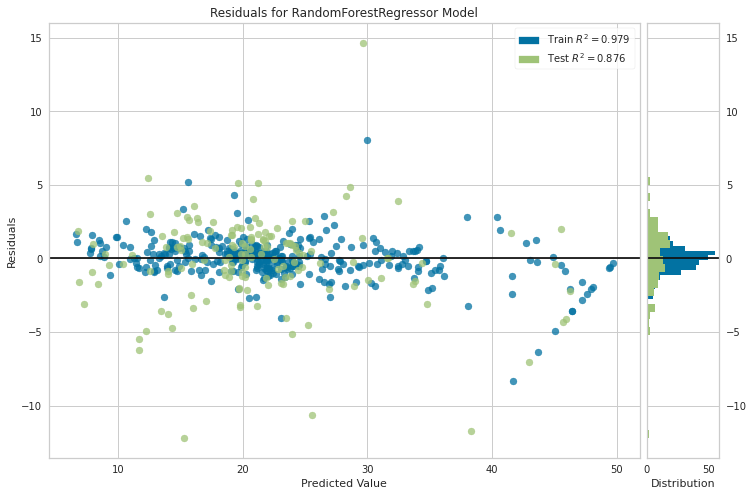

In [17]:
from yellowbrick.regressor import ResidualsPlot

fig, ax = plt.subplots(figsize=(12, 8))
rpv = ResidualsPlot(rfr)
rpv.fit(X_train, y_train.values.ravel())
rpv.score(X_test, y_test.values.ravel())
rpv.poof()
fig.savefig("images/regression_metrics_residuals_plot.png", dpi=300)

## Heteroscedasticity
The `statsmodel` library includes the **Breusch-Pagan test for heteroscedasticity**. This means that variance of the residuals varies over the predicted values. In the Breusch-Pagan test, if the p-values are significant (p-value less than 0.05), the null hypothesis of homoscedasticity is rejected. This indicates that residuals are `heteroscedastic`, and the predictions are biased.

In [30]:
import statsmodels.stats.api as sms

resids = (y_test.values.ravel() - rfr.predict(X_test))

hb = sms.het_breuschpagan(resids, X_test)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]

for label, num in zip(labels, hb):
    print(f"{label}: {num:.2}")

Lagrange multiplier statistic: 3.8e+01
p-value: 0.00016
f-value: 3.5
f p-value: 8.6e-05


## Normal Residuals
The `scipy` library includes a probability plot and the **Kolmogorov-Smirnov test**, both of which **measure whether the residuals are normal**.

### Histogram
We can plot a histogram to visualize the residuals and check for normality.

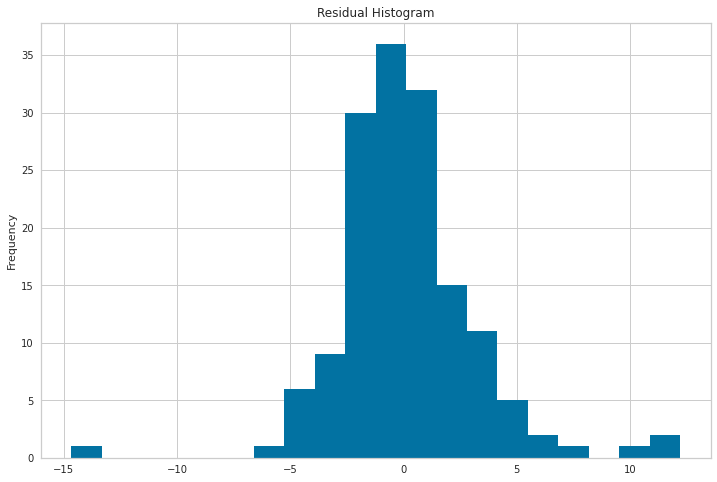

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
resids = y_test.values.ravel() - rfr.predict(X_test)
pd.Series(resids, name="residuals").plot.hist(bins=20, ax=ax, title="Residual Histogram")
fig.savefig("images/regression_metrics_normal_residuals.png", dpi=300)

### Probability plot
If the samples plotted against the quantiles line up, the residuals are normal. We can see that this fails in this case.

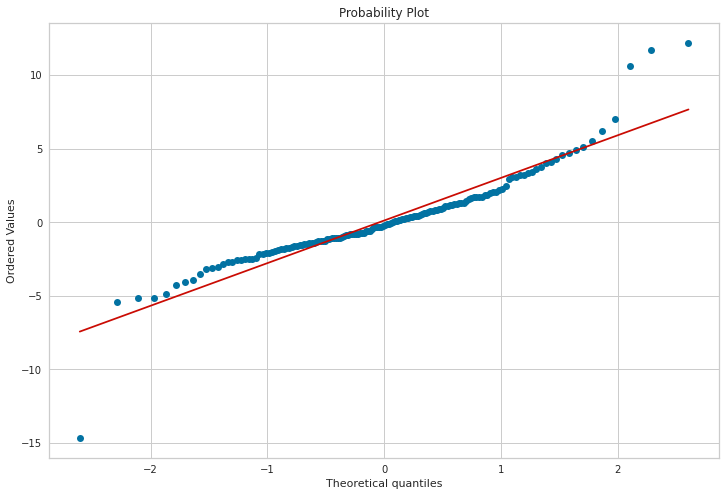

In [34]:
from scipy import stats

fig, ax = plt.subplots(figsize=(12, 8))
_ = stats.probplot(resids, plot=ax)
fig.savefig("images/regression_metrics_probability_plot.png", dpi=300)

The **Kolmogorov-Smirnov test can evaluate whether a distribution is normal**. If the p-value is significant (< 0.05), then the values are not normal.

This fails as well, which tells us the residuals are not normal.

In [35]:
stats.kstest(resids, cdf="norm")

KstestResult(statistic=0.2070667244097814, pvalue=3.410190989297583e-06)

## Prediction Error Plot
A prediction error plot shows the real targets against the predicted values. For a perfect model these points would line up in a 45-degree line.

As our model seems to predict lower values for the high end of y, the model has some performance issues. This is also evident in the residuals plot.

In [19]:
y_test.values.ravel()

array([23.6, 32.4, 13.6, 22.8, 16.1, 20. , 17.8, 14. , 19.6, 16.8, 21.5,
       18.9,  7. , 21.2, 18.5, 29.8, 18.8, 10.2, 50. , 14.1, 25.2, 29.1,
       12.7, 22.4, 14.2, 13.8, 20.3, 14.9, 21.7, 18.3, 23.1, 23.8, 15. ,
       20.8, 19.1, 19.4, 34.7, 19.5, 24.4, 23.4, 19.7, 28.2, 50. , 17.4,
       22.6, 15.1, 13.1, 24.2, 19.9, 24. , 18.9, 35.4, 15.2, 26.5, 43.5,
       21.2, 18.4, 28.5, 23.9, 18.5, 25. , 35.4, 31.5, 20.2, 24.1, 20. ,
       13.1, 24.8, 30.8, 12.7, 20. , 23.7, 10.8, 20.6, 20.8,  5. , 20.1,
       48.5, 10.9,  7. , 20.9, 17.2, 20.9,  9.7, 19.4, 29. , 16.4, 25. ,
       25. , 17.1, 23.2, 10.4, 19.6, 17.2, 27.5, 23. , 50. , 17.9,  9.6,
       17.2, 22.5, 21.4, 12. , 19.9, 19.4, 13.4, 18.2, 24.6, 21.1, 24.7,
        8.7, 27.5, 20.7, 36.2, 31.6, 11.7, 39.8, 13.9, 21.8, 23.7, 17.6,
       24.4,  8.8, 19.2, 25.3, 20.4, 23.1, 37.9, 15.6, 45.4, 15.7, 22.6,
       14.5, 18.7, 17.8, 16.1, 20.6, 31.6, 29.1, 15.6, 17.5, 22.5, 19.4,
       19.3,  8.5, 20.6, 17. , 17.1, 14.5, 50. , 14

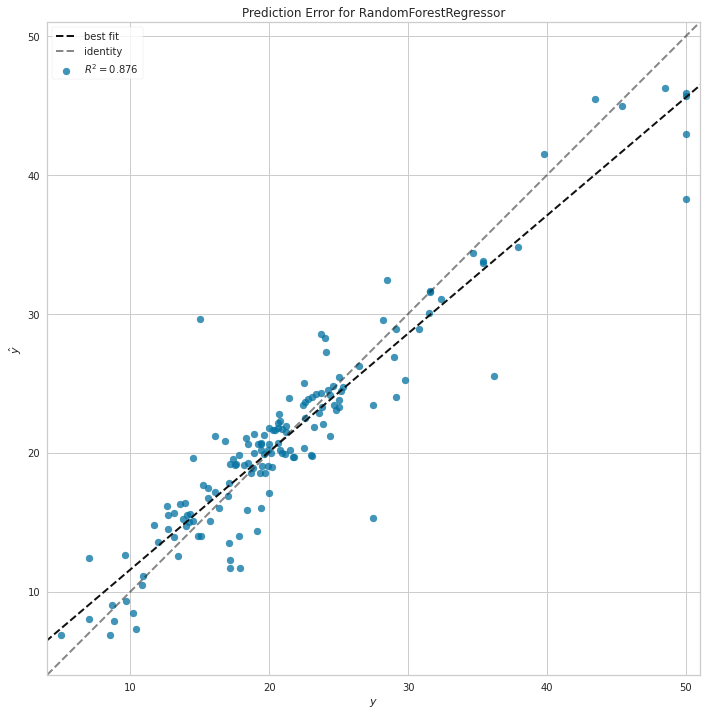

In [37]:
from yellowbrick.regressor import PredictionError

fig, ax = plt.subplots(figsize=(12, 12))
pev = PredictionError(rfr)
pev.fit(X_train, y_train.values.ravel())
pev.score(X_test, y_test.values.ravel())
pev.poof()
fig.savefig("images/regression_metrics_prediction_error_plot.png", dpi=300)